In [1]:
from evoVAE.utils.datasets import MSA_Dataset
import evoVAE.utils.seq_tools as st
import evoVAE.utils.metrics as mt
from evoVAE.models.seqVAETest import SeqVAETest
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import numpy as np

pd.set_option("display.max_rows", None)

This notebook can be used to test new features for a model without having to use the WandB service

# Config

In [2]:
config = {
        # Dataset info
        "dataset": "playground",
        "seq_theta": 0.2, # reweighting 
        "AA_count": 21, # standard AA + gap
        
        # ADAM 
        "learning_rate": 1e-5, # ADAM
        "weight_decay": 0.01, # ADAM

        # Hidden units 
        "momentum": 0.1, 
        "dropout": 0.5,

        # Training loop 
        "epochs": 100,
        "batch_size": 128,
        "max_norm": 1.0, # gradient clipping
        
        # Model info
        "architecture": "SeqVAETest",
        "latent_dims": 2,
        "hidden_dims": [32, 16],
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Read in data

In [3]:
from pathlib import Path
DATA_PATH = "/Users/sebs_mac/OneDrive - The University of Queensland/honours/data/gfp_alns/independent_runs/no_synthetic/ancestors/auto_rooted/ancestors/"
filepath = DATA_PATH + 'run_14_ancestors.fa'
aln = st.read_aln_file(filepath)
#


Reading the alignment: /Users/sebs_mac/OneDrive - The University of Queensland/honours/data/gfp_alns/independent_runs/no_synthetic/ancestors/auto_rooted/ancestors/run_14_ancestors.fa
Checking for bad characters: ['B', 'J', 'X', 'Z']
Performing one hot encoding
Number of seqs: 359


In [4]:
from evoVAE.utils.seq_tools import encode_and_weight_seqs


code, weight = encode_and_weight_seqs(aln['sequence'], 0.2)
aln['weight'] = weight

Encoding the sequences and calculating weights
The sequence encoding has size: (359,)

The sequence weight array has size: (359,)



In [5]:
aln.head()

,id,sequence,encoding,weight
0,N0,MSSGALLFHGKIPYVVEMEGDVDGHKFSVRGKGHGDATTGKIEAKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.166667
1,N1,MSSGALLFHEKIPYVVEMEGDVDGMKFSVRGKGHGDATTGKIEAKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.166667
2,N2,MSAGALLFQQKIPYIVELEGDVNGMKFSVRGKGTGDATTGKIEAKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.125000
3,N3,-SAGALLFQQKIPYIVELEGDVNGMKFTVRGKGTGDATTGTIEAKF...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.125000
4,N4,-SAGALLLKQKVPFIMELDAEVNGIRFAVRGKGTGDATTGTIEAKF...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.125000


In [6]:

train, val = train_test_split(aln, test_size=0.2)


# TRAINING
train_dataset = MSA_Dataset(
    train["encoding"], train['weight'], train["id"]
)

# VALIDATION
val_dataset = MSA_Dataset(
    val["encoding"], val['weight'], val["id"]
)

# DATA LOADERS #
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

print(len(train_loader), len(val_loader))
#next(iter(train_loader))[0].shape

9 3


# Build model

In [7]:
# get the sequence length 
SEQ_LEN = 0
BATCH_ZERO = 0
SEQ_ZERO = 0
seq_len = train_dataset[BATCH_ZERO][SEQ_ZERO].shape[SEQ_LEN]
input_dims = seq_len * config['AA_count']

seq_len, input_dims

# use preset structure for hidden dimensions 
model = SeqVAETest(input_dims=input_dims, latent_dims=config['latent_dims'], hidden_dims=config['hidden_dims'], config=config) 

model.eval()
for encoding, weights, _ in train_loader:

    encoding = encoding.float()
    weights = weights.float()
    #print(encoding.shape, weight.shape)
    modelOutputs = model(encoding)
    loss, kl, likelihood = model.loss_function(modelOutputs, encoding, weights)

In [8]:
# very small nummy data 
dummy = next(iter(train_loader))[0].float()
print(dummy.shape)
# reconstruct input, note it has been flattened 
log_p, z_sample, z_mu, z_logvar = model(dummy)

# grab the shape of the input for reshaping
orig_shape = log_p.shape[0:-1]

# add on extra dim, then make it one-hot encoding shape (obs, seq_len, AA_count)
log_p = torch.unsqueeze(log_p, -1)
log_p = log_p.view(orig_shape + (-1, config['AA_count']))

torch.Size([32, 238, 21])


In [9]:
mut_data = pd.read_csv('../data/dms_data/GFP_AEQVI_Sarkisyan_2016.csv')
subset = mut_data.copy()[0:10]

FileNotFoundError: [Errno 2] No such file or directory: '../data/dms_data/GFP_AEQVI_Sarkisyan_2016.csv'

In [ ]:
encoding, _ = st.encode_and_weight_seqs(mut_data['mutated_sequence'], 0.2, reweight=False)
mut_data['encoding'] = encoding
mut_data[0:10]

In [ ]:
mut_data.to_pickle("GFP_AEQVI_Sarkisyan_2016_dms_encoded.pkl")

In [ ]:
encoding, weights = st.encode_and_weight_seqs(subset['mutated_sequence'], 0.2, reweight=True)
subset['encoding'] = encoding
subset['weights'] = weights
subset

In [ ]:
metadata = pd.read_csv("../data/dms_data/DMS_substitutions.csv")
metadata = metadata[metadata["DMS_id"].str.contains("GFP")]
metadata


In [ ]:

import sklearn
import sklearn.preprocessing


wild_type = metadata['target_seq'].to_numpy()[0]
wild_one_hot = torch.Tensor(st.seq_to_one_hot(wild_type)).unsqueeze(0)

model.eval()
wild_model_encoding, _, _, _ = model(wild_one_hot)

orig_shape = wild_model_encoding.shape[0:-1]

wild_model_encoding = torch.unsqueeze(wild_model_encoding, -1)

wild_model_encoding = wild_model_encoding.view(orig_shape + (-1, model.AA_COUNT))


# get the wild type encoding 
wild_model_encoding = wild_model_encoding.squeeze(0)

one_hot = wild_one_hot.squeeze(0)
wt_prob = mt.seq_log_probability(one_hot, wild_model_encoding)

variant_encodings = torch.Tensor(np.stack(subset['encoding'].values))
variant_model_outputs, _, _, _ = model(variant_encodings)

model_scores =[]
for variant, var_one_hot in zip(variant_model_outputs, variant_encodings):
    
    print(variant.shape)
    var_model_encoding = torch.unsqueeze(variant, -1)
    print(var_model_encoding.shape)
    var_model_encoding = var_model_encoding.view(orig_shape + (-1, model.AA_COUNT))
    var_model_encoding = var_model_encoding.squeeze(0)
    log_prob = mt.seq_log_probability(var_one_hot, var_model_encoding)
    
    # make variant fitness relative to the wild type
    model_scores.append(log_prob - wt_prob)
    
model_scores = pd.Series(model_scores)
model_scores, subset['DMS_score']



In [ ]:
a = torch.Tensor([0,0,0])
b = torch.Tensor([1,2,3])
a - b

In [ ]:
spear_rho, k_recall, ndcg, roc_auc = mt.summary_stats(predictions=model_scores, actual=subset['DMS_score'], actual_binned=subset['DMS_score_bin'])
spear_rho, k_recall, ndcg, roc_auc

Reading the alignment: ../data/test.aln
Checking for bad characters: ['B', 'J', 'X', 'Z']
Performing one hot encoding
Number of seqs: 6


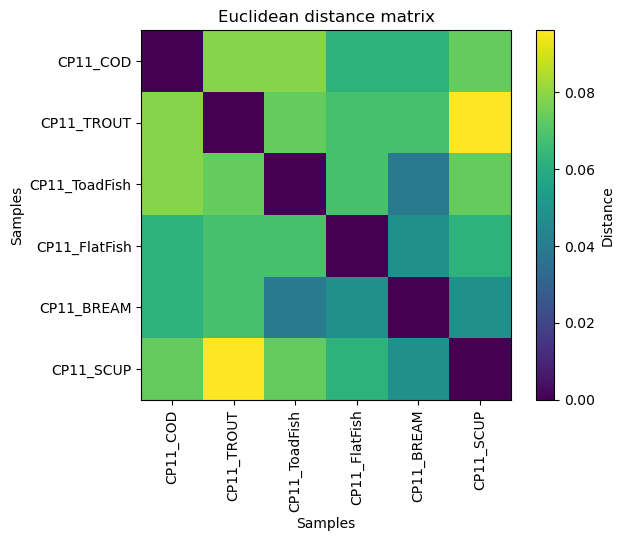

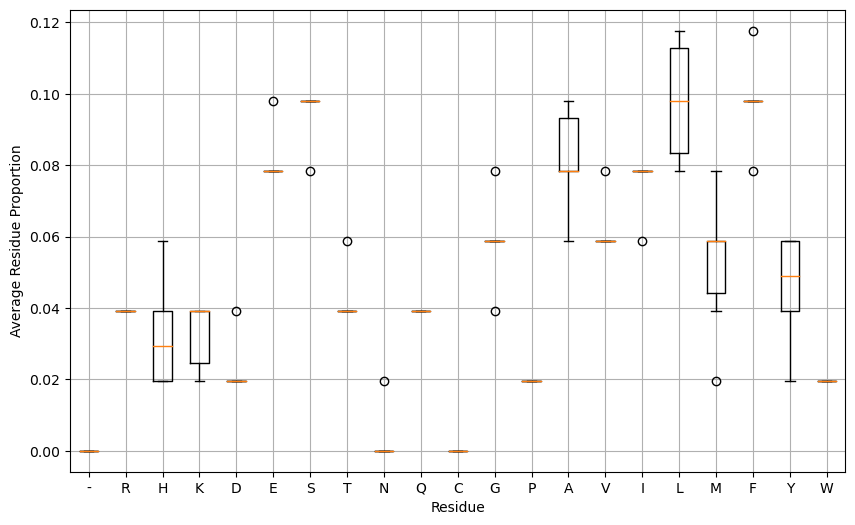

In [ ]:
import evoVAE.utils.seq_tools as st
from evoVAE.utils.seq_tools import GAPPY_PROTEIN_ALPHABET, calc_position_prob_matrix, calc_mean_seq_embeddings, calc_position_prob_matrix, create_euclidean_dist_matrix, plot_residue_distributions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List

seqs = st.read_aln_file("../data/test.aln")
encode = calc_mean_seq_embeddings(seqs)
ppm = calc_position_prob_matrix(seqs)


create_euclidean_dist_matrix(encode, plot=True)


plot_residue_distributions(encode)
#print(ppm)
#print()
#print(avgs)


131941395333120000

In [ ]:
x = []
y = []
all = []

with open("sample_0.01.output", 'r') as file:
    lines = file.readlines()
    for line in lines:
        data = line.strip().split(',')
        print(data)
        all.append(data)

        x.append(float(data[0]))
        y.append(float(data[1]))

['0.01', '0.04762638852845307', '0.050886254967317905', '']
['0.02', '0.050126899764635836', '0.05309434320609099', '']
['0.03', '0.04719504384688042', '0.050451984427058456', '']
['0.04', '0.04994887356183516', '0.052489141664580886', '']
['0.05', '0.0478489947726014', '0.05097584099001541', '']
['0.060000000000000005', '0.04940291305144089', '0.05154003353921704', '']
['0.06999999999999999', '0.049234160107671364', '0.05196157165776881', '']
['0.08', '0.04911268772214578', '0.05284066030990331', '']
['0.09', '0.04899572856551402', '0.051329412842480424', '']
['0.09999999999999999', '0.047762474130245085', '0.04975584910964321', '']
['0.11', '0.04882748950930503', '0.051546634593853946', '']
['0.12', '0.048661603978982046', '0.05091697207916727', '']
['0.13', '0.04885737715156598', '0.05085680991194603', '']
['0.14', '0.049648191445055855', '0.0529347848111767', '']
['0.15000000000000002', '0.049195624449473986', '0.05204468298754328', '']
['0.16', '0.04739870603267984', '0.0488818244

['1.0', '0.048471730579100314', '0.05086100683556503', '']
[0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.048765376738978, 0.0487653

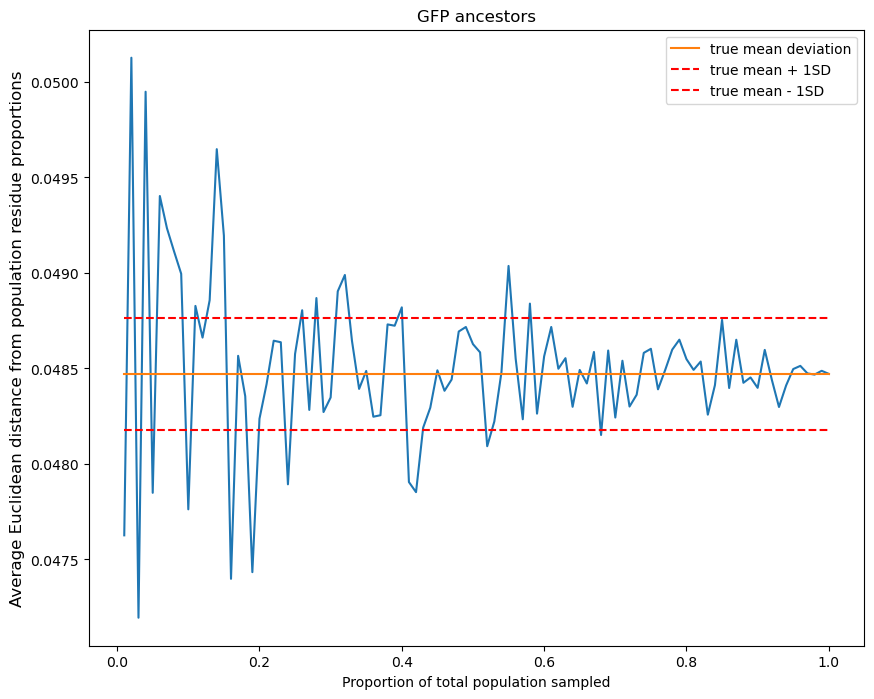

In [ ]:



print(all[-1])
error_plus = [(float(all[-1][1]) + float(all[-1][2])/np.sqrt(30000)) for x in range(len(x))]
error_neg = [(float(all[-1][1]) - float(all[-1][2])/np.sqrt(30000)) for x in range(len(x))]
print(error_plus)
plt.figure(figsize=(10,8))
plt.plot(x,y)
plt.plot(x, [float(all[-1][1]) for x in range(len(x))], label='true mean deviation')
plt.plot(x,error_plus, '--r', label="true mean + 1SD")
plt.plot(x,error_neg, '--r', label="true mean - 1SD")
plt.title("GFP ancestors")
plt.ylabel("Average Euclidean distance from population residue proportions", size=12)
plt.xlabel("Proportion of total population sampled")
plt.legend()



In [76]:
from asyncio import as_completed
import concurrent.futures
import evoVAE.utils.metrics as mt
import numpy as np
import evoVAE.utils.seq_tools as st 
import multiprocessing


def mini_pro(seq_idx, sequences, theta):
    
    weights = np.zeros(len(sequences))

    for j in range(seq_idx + 1, len(sequences)):
        if (
            mt.hamming_distance(sequences[seq_idx], sequences[j]) / len(sequences[seq_idx])
            < theta
        ):
            weights[seq_idx] += 1
            weights[j] += 1

    print(weights)
    return weights


def reweight_sequences(sequences: np.ndarray, theta: float) -> np.ndarray:
    """Take in a Series of sequences and calculate the new weights. Sequences
    are deemed to be clustered if (mutation_count/seq_len) < theta."""

    main_matrix = np.ones(len(sequences))

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(mini_pro, seq_idx, sequences, theta) for seq_idx in range(len(sequences))]
        for future in concurrent.futures.as_completed(futures):
            
            result = future.result()
            main_matrix += result
 

    return np.fromiter((map(lambda x: 1.0 / x, main_matrix)), dtype=float)

def reweight_sequences_multi(sequences: np.ndarray, theta: float) -> np.ndarray:
    """
    Take in a Series of sequences and calculate the new weights. Sequences
    are deemed to be clustered if (mutation_count/seq_len) < theta.

    This function uses ProcessPoolExecutor for parallel processing.
    """

    main_matrix = np.ones(len(sequences))

    args = ((seq_idx, sequences, theta) for seq_idx in range(len(sequences)))
    
    # Use ProcessPoolExecutor for true parallel processing across cores
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Submit tasks efficiently using map
        results = executor.map(lambda x: mini_pro(*args), args)
        # Efficiently update main_matrix using a loop (avoiding unnecessary accumulation with +=)
        print(results)
     
    return main_matrix




In [45]:
test = st.read_aln_file("../data/test_3.aln", encode=True)
test

Reading the alignment: ../data/test_3.aln
Checking for bad characters: ['B', 'J', 'X', 'Z']
Performing one hot encoding
Number of seqs: 3


,id,sequence,encoding
0,CP11_COD,AGFDTVSTALSWSVMYLVAHPEIQERLHQEIKAFIFEIFRHSSFML...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,CP11_TROUT,AGFDTISTALSWAVVYLVAYPEIQERLHQELKAFILEIFRHSSFLV...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,CP11_ToadFish,AGFDTVSTGLSWSVMYLVAYPEIQERLYQEIKAFILEIFRHSSFML...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
import time


start = time.time()
array = st.reweight_sequences(test['sequence'], 0.2)

print("took:", time.time() - start)


start = time.time()
array = reweight_sequences_multi(test['sequence'], 0.2)

print("took:", time.time() - start)

